## Import & Setup

Note, you can ignore this error:

```
ISAAC SIM may not to be installed. Please install it to use full GO4R functionality.
```

This message appears because this notebook imports packages from the GO4R extension, but it _does not_ need Isaac Sim.

In [1]:
#Enable reloading because restarting the kernel is a pain
%load_ext autoreload
%autoreload 2

%pip install -q usd-core
%pip install -q pymoo
%pip install -U kaleido

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import numpy as np

from isaacsim.extsUser.go4robo.go4robo_python.bot_3d_problem import *
from isaacsim.extsUser.go4robo.go4robo_python.bot_3d_rep import *

import json

import os, sys

import copy

import plotly.graph_objects as go
import seaborn as sns
import pandas as pd

from tqdm.notebook import trange, tqdm

sns.set_style("whitegrid")
sns.set_palette("husl")
sns.set_context("notebook", font_scale=1.5)

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ISAAC SIM may not to be installed. Please install it to use full GO4R functionality.



Traceback (most recent call last):
  File "/home/rachael/Documents/GitHub/go4robo/isaacsim/extsUser/go4robo/go4robo_python/__init__.py", line 10, in <module>
    from .extension import *
  File "/home/rachael/Documents/GitHub/go4robo/isaacsim/extsUser/go4robo/go4robo_python/extension.py", line 3, in <module>
    import omni.ext
ModuleNotFoundError: No module named 'omni'


Isaac Sim not found; Isaac Sim-specific features will not work.
USD not found; USD-specific features will not work.
Open3D not found; Open3D-specific features will not work.


### !! Put the run ID here !!

In [2]:
robot_name = "jackal"
run_date_string = "20250504"
run_time_string = "005254"

run_id = f"{robot_name}_{run_date_string}_{run_time_string}"

## Get the Problem & Solution Data

### Problem from the JSON

In [3]:
results_dir = f"/home/rachael/Documents/GitHub/go4robo/isaacsim/extsUser/go4robo/go4robo_python/results/"
json_prolem_path = f"{results_dir}problem_{run_id}.json" # This will contain the prior design at problem.prior_bot

problem_json_dict = json.load(open(json_prolem_path, 'r'))

problem = SensorPkgOptimization.from_json(problem_json_dict)

SensorPkgOptimization initialized. Bounds: [[-0.19962713  0.24037287]
 [-0.18        0.18      ]
 [ 0.18642105  0.38642105]]


### Generated designs from CSV

In [4]:
df_csv_path = f"/home/rachael/Documents/GitHub/go4robo/isaacsim/extsUser/go4robo/go4robo_python/results/designs_{run_id}.csv" # This should also contain the prior design at index 0

df = pd.read_csv(df_csv_path)

#### Add some additional stats to the DT for visualization

In [5]:
new_headers = []

# Add up the different sensor types
for k, so in problem.sensor_options.items():
    if so is None:
        continue
    sensor_option_name = so.name
    new_headers.append(f"Total '{sensor_option_name}'s ({k})")
    df[f"Total '{sensor_option_name}'s ({k})"] = (df[[f"s{i}_type" for i in range(problem.max_n_sensors)]] == k).sum(axis=1)

# Add up the total sensors
df[f"Total Sensors"] = df[new_headers].sum(axis=1)
new_headers.append(f"Total Sensors")

In [6]:
df

,id,Name,Cost,Perception Entropy,Generation,s0_type,s0_x,s0_y,s0_z,s0_qw,...,s7_x,s7_y,s7_z,s7_qw,s7_qx,s7_qy,s7_qz,Total 'sick_lms1xx_lidar_frame's (1),Total 'bumblebee_stereo_camera_frame's (2),Total Sensors
0,0,Prior Design,1300.0,-5.393220,0,1,0.120000,0.000000,0.333000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,2
1,1,Design 1,2500.0,-9.151512,1,1,-0.189544,0.006870,0.348419,0.088574,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1,3
2,2,Design 2,3900.0,-5.598715,1,1,0.140845,-0.026015,0.347961,0.364928,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3,6
3,3,Design 3,2700.0,-6.006595,1,1,-0.065639,0.120547,0.273482,0.493898,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,3,5
4,4,Design 4,1500.0,6.769386,1,2,0.216309,-0.026798,0.342857,-0.156360,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7486,7486,Design 7486,200.0,6.924146,107,2,0.110109,-0.054041,0.366416,-0.459969,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2,2
7487,7487,Design 7487,2900.0,-10.524057,107,2,0.136662,-0.068577,0.371723,-0.819115,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,5,7
7488,7488,Design 7488,600.0,2.781189,107,2,0.116501,0.154598,0.360893,-0.538190,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,6,6
7489,7489,Design 7489,1300.0,-9.865841,107,2,0.037566,-0.063578,0.378237,-0.778565,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,2


## Objective Trade Space

Conveniently you can do this without the Problem definition, assuming you used the standard problem definition.

In [7]:
obj_trade_fig = plot_tradespace(df)
obj_trade_fig

In [8]:
# Save the objective trade space figure as a PNG
output_path = os.path.join(results_dir, f"TRADESPACE_{run_id}.png")
obj_trade_fig.write_image(output_path)
print(f"Saved tradespace to {output_path}")

Saved tradespace to /home/rachael/Documents/GitHub/go4robo/isaacsim/extsUser/go4robo/go4robo_python/results/TRADESPACE_jackal_20250504_005254.png


## Pair Plots

/tmp/ipykernel_62192/1894675715.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_62192/1894675715.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



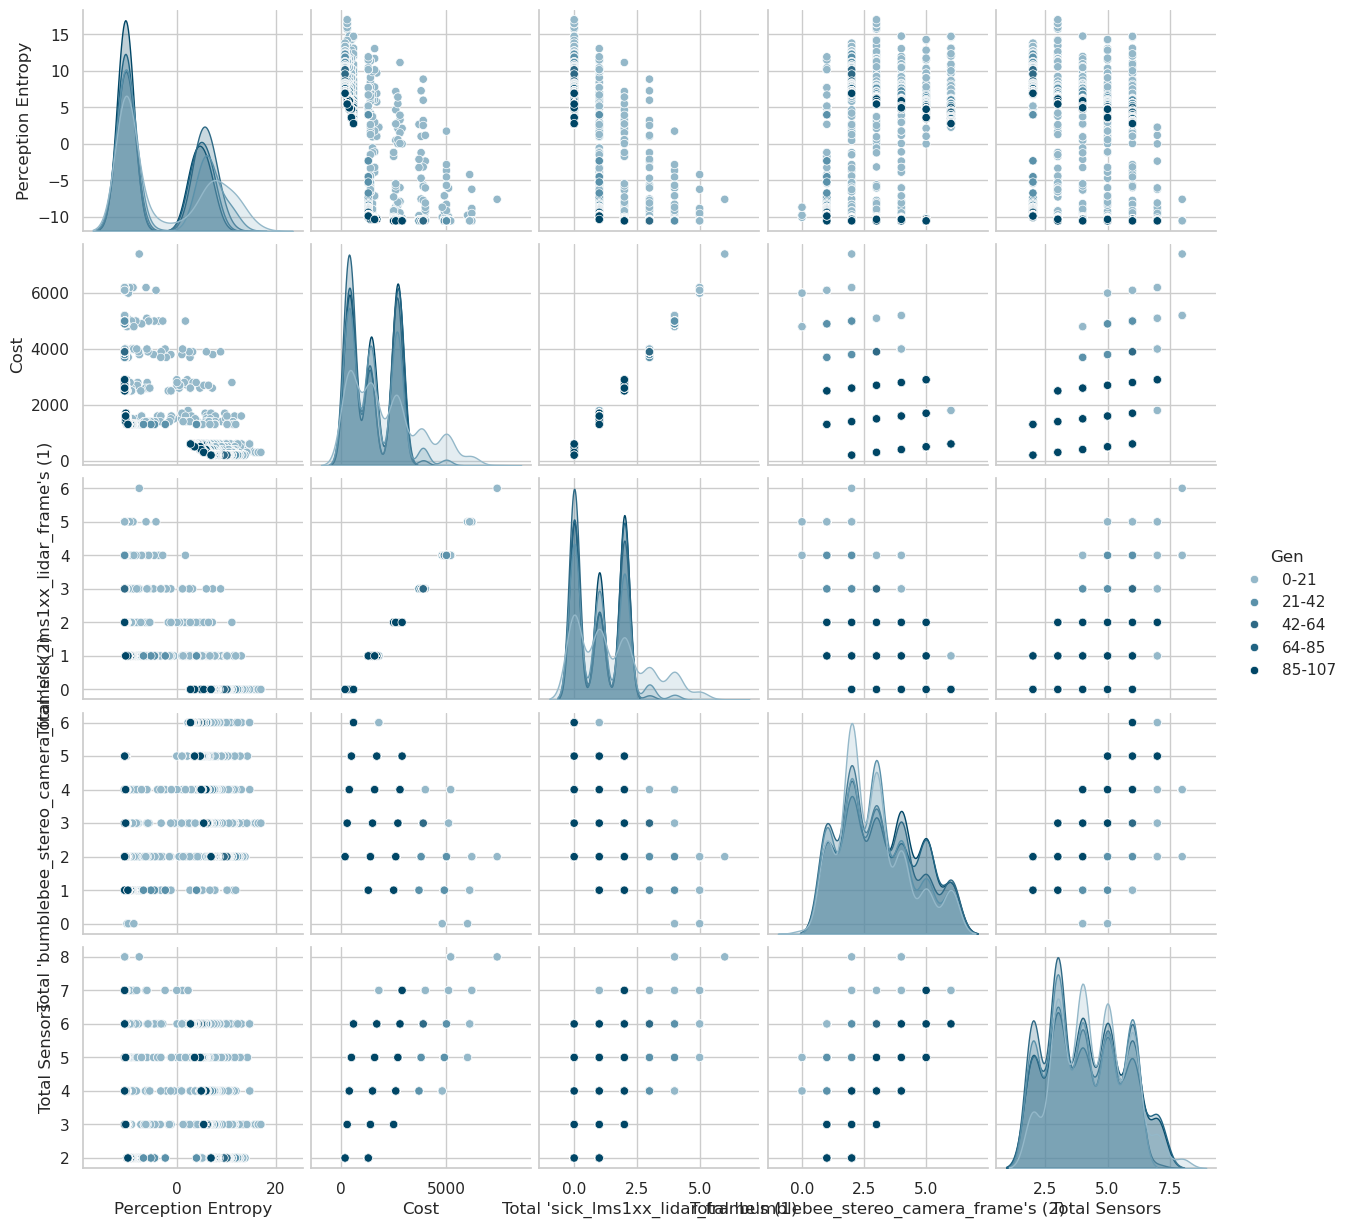

In [16]:
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1)
sns_blues = sns.color_palette(color_scale_blue)
sns.set_palette(sns_blues)

pair_plot_df = df[["Generation", "Perception Entropy", "Cost"] + new_headers]
# Bin generations into 5 groups and label each bin "X-Y"
gen_cat = pd.cut(pair_plot_df["Generation"], bins=5, include_lowest=True)
bin_labels = [f"{int(interval.left)}-{int(interval.right)}" for interval in gen_cat.cat.categories]
pair_plot_df["Gen"] = gen_cat.cat.rename_categories(bin_labels)
pair_plot_df.drop(columns=["Generation"], inplace=True)

pair_plot_fig = sns.pairplot(
    pair_plot_df,
    hue="Gen",
    diag_kind="kde",
    palette=sns_blues
    )


In [17]:
# Save the pair plot figure as a PNG
output_path = os.path.join(results_dir, f"PAIR_PLOT_{run_id}.png")
pair_plot_fig.savefig(output_path, dpi=400)
print(f"Saved pair plot to {output_path}")

Saved pair plot to /home/rachael/Documents/GitHub/go4robo/isaacsim/extsUser/go4robo/go4robo_python/results/PAIR_PLOT_jackal_20250504_005254.png


## Plot any bot from the df above

### Helper fns and data

In [11]:
sensor_constraints_mesh_data = box_mesh_data(problem.s_bounds, color="blue", opacity=0.2, name="Sensor Pos Constraints")

def plot_plot_design(design_idx, sensor_idx_rays=None, max_rays=100):
    design_x_df = df[df["id"] == design_idx]
    design_x_dict = design_x_df.iloc[0].to_dict()
    bot_x = problem.convert_1D_to_bot(design_x_dict)
    sensor_x:Sensor3D_Instance = bot_x.sensors[sensor_idx_rays] if sensor_idx_rays is not None else None
    design_x_fig = bot_x.plot_bot_3d(
        perception_space=problem.perception_space,
        show=False,
        show_sensor_pose_constraints=False,
        width=600,
    )
    design_x_fig.add_trace(sensor_constraints_mesh_data)

    if sensor_x is not None:
        ro, rd = sensor_x.get_rays()
        sparse = int(ro.shape[0] / max_rays)
        sensor_x.plot_rays(ro, rd, sparse=sparse, fig=design_x_fig)
    
    design_x_fig.update_layout(
        title=f"Design {design_idx}",
        scene=dict(
            xaxis_title="X",
            yaxis_title="Y",
            zaxis_title="Z",
            aspectmode="data",
        ),
        margin=dict(l=0, r=0, b=0, t=30),
    )

    return design_x_fig, design_x_df

### Plot any Bot!

In [12]:
# Here is the first one
design_0_fig, design_0_df = plot_plot_design(0, sensor_idx_rays=0, max_rays=100)

design_0_df

Found sensor type 1 in problem sensor options.
Found sensor type 2 in problem sensor options.


,id,Name,Cost,Perception Entropy,Generation,s0_type,s0_x,s0_y,s0_z,s0_qw,...,s7_y,s7_z,s7_qw,s7_qx,s7_qy,s7_qz,Total 'sick_lms1xx_lidar_frame's (1),Total 'bumblebee_stereo_camera_frame's (2),Total Sensors,Pareto Optimal
0,0,Prior Design,1300.0,-5.39322,0,1,0.12,0.0,0.333,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1,2,


In [19]:
INDEX_TO_PLOT = 7433
design_x_fig, design_x_df = plot_plot_design(INDEX_TO_PLOT, sensor_idx_rays=1, max_rays=100)
design_x_df

Found sensor type 2 in problem sensor options.
Found sensor type 2 in problem sensor options.
Found sensor type 1 in problem sensor options.


,id,Name,Cost,Perception Entropy,Generation,s0_type,s0_x,s0_y,s0_z,s0_qw,...,s7_y,s7_z,s7_qw,s7_qx,s7_qy,s7_qz,Total 'sick_lms1xx_lidar_frame's (1),Total 'bumblebee_stereo_camera_frame's (2),Total Sensors,Pareto Optimal
7433,7433,Design 7433,1400.0,-10.318009,107,2,0.133697,-0.063055,0.366445,-0.470736,...,0.0,0.0,0.0,0.0,0.0,0.0,1,2,3,Pareto Optimal


## Random Testing

### Ray/Voxel Traversal (measurement) test case

In [14]:
ro, rd = torch.tensor([[0.0, 0.0, 0.0],[0.0, 0.0, 0.0],[0.0, 0.0, 0.0]]), torch.tensor([[1.0, 0.0, 0.0],[0.0, 1.0, 0.0],[np.sqrt(0.5), np.sqrt(0.5), 0.0]])

simple_perception_space = PerceptionSpace(usd_context=None,
                                          voxel_groups=[PerceptionSpace.VoxelGroup(
                                                name="simple",
                                                voxels=['','','',''],
                                                voxel_centers=torch.tensor([
                                                    [-0.5, -0.5, 0.0],  # Behind the sensor, should have 0 hits
                                                    [0.0, 0.0, 0.0],    # At center of sensor, should have 3 hits
                                                    [0.5, 0, 0.0],      # Along x-axis, should have 1 hit
                                                    [1.0, 0.5, 0.0]     # Should have 0 hits
                                                    ]),
                                                voxel_sizes=torch.tensor([0.1,0.1,0.1,0.1]).unsqueeze(1),
                                          )
                                          ],
                                          weights=[1.0]
)

simple_sensor:Sensor3D_Instance = Sensor3D_Instance(
    sensor=Sensor3D(
        name="simple_sensor",
    ),
    path='',
    tf=((0, 0, 0), (1, 0, 0, 0)),
    name="simple_sensor_instance",
)
    

# display(torch.tensor([[1.0, 0, 0.5],[2.0, 0, 0.5]]).size())
# display(torch.tensor([0.5,0.5]).size())

one_ray_fig = simple_perception_space.plot_me(show=False, mode='boxes')
simple_sensor.plot_rays(ro, rd, show=False, fig=one_ray_fig, ray_length=1.25)


one_ray_fig

In [15]:
simple_perception_space.chunk_ray_voxel_intersections(ro, rd, verbose=True)
# simple_perception_space.batch_ray_voxel_intersections(ro, rd, verbose=True)

 Batch ray voxel intersection traversal took 0.04 seconds for 3 rays and 4 voxels.
  VOXEL HITS max: 3, min: 0


tensor([0, 3, 1, 0], device='cuda:0')